This notebook is a little easier for beginners because it uses pytorch. You need to clone a repo to get it working:

```sh
# you need this repo, so clone it
git clone https://github.com/wassname/DeepRL.git
cd DeepRL
git reset --hard aeae2c5d585e5853dc638968b1f090eb60abd351
cd ..
mkdir data log evaluation_log
```

This contains some minor modifications from https://github.com/ShangtongZhang/DeepRL.git

The notebook tries DPPG with the [EIIE model](https://arxiv.org/pdf/1706.10059.pdf)

I also uncommented reward normalization in DDPG_agent.py#L64 because otherwise my small reward les to large Q's, inf losses, and NaN actions and weights.(https://github.com/wassname/rl-portfolio-management)

In [1]:
# plotting
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
os.sys.path.append(os.path.abspath('DeepRL'))
%reload_ext autoreload
%autoreload 2

In [3]:
# params
window_length = 50
steps = 252



In [4]:
# save dir
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

save_path = './outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-%s.model' % ts
save_path
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass

In [5]:
# setup tensorboard logging
from tensorboard_logger import configure, log_value
tag = 'ddpg-' + ts
print('tensorboard --logdir '+"runs/" + tag)
try:
    configure("runs/" + tag)
except ValueError as e:
    print(e)
    pass

tensorboard --logdir runs/ddpg-20211116_07-29-04


# Env

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.util import MDD, sharpe, softmax, MDD1, sortino
from rl_portfolio_management.wrappers import MinmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/chinaStock_1d.hf',key='train')
df_test = pd.read_hdf('./data/chinaStock_1d.hf',key='test')


In [7]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [8]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = MinmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = MinmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 5), (4, 51, 5))

# Agent and models

In [9]:
# load
import pickle
import shutil

def save_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    agent.save(save_file)
    print(save_file)
    

def load_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    new_states = pickle.load(open(save_file, 'rb'))
    states = agent.worker_network.load_state_dict(new_states)


def load_stats_ddpg(agent):
    agent_type = agent.__class__.__name__
    online_stats_file = 'data/%s-%s-online-stats-%s.bin' % (
                    agent_type, config.tag, agent.task.name)
    try:
        steps, rewards = pickle.load(open(online_stats_file, 'rb'))
    except FileNotFoundError:
        steps =[]
        rewards=[]
    df_online = pd.DataFrame(np.array([steps, rewards]).T, columns=['steps','rewards'])
    if len(df_online):
        df_online['step'] = df_online['steps'].cumsum()
        df_online.index.name = 'episodes'
    
    stats_file = 'data/%s-%s-all-stats-%s.bin' % (agent_type, config.tag, agent.task.name)
    try:
        stats = pickle.load(open(stats_file, 'rb'))
    except FileNotFoundError:
        stats = {}
    df = pd.DataFrame(stats["test_rewards"], columns=['rewards'])
    if len(df):
#         df["steps"]=range(len(df))*50

        df.index.name = 'episodes'
    return df_online, df

In [10]:
import logging
from agent import ProximalPolicyOptimization, DisjointActorCriticNet #, DeterministicActorNet, DeterministicCriticNet
from component import GaussianPolicy, HighDimActionReplay, OrnsteinUhlenbeckProcess
from utils import Config, Logger
import gym
import torch
gym.logger.setLevel(logging.INFO)

# Alg

In [11]:
# Modified from https://github.com/ShangtongZhang/DeepRL to log to tensorboard

from utils.normalizer import Normalizer

null_normaliser = lambda x:x

class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.task = config.task_fn()
        self.worker_network = config.network_fn()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.worker_network.state_dict())
        self.actor_opt = config.actor_optimizer_fn(self.worker_network.actor.parameters())
        self.critic_opt = config.critic_optimizer_fn(self.worker_network.critic.parameters())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn()
        self.criterion = nn.MSELoss()
        self.total_steps = 0

        self.state_normalizer = Normalizer(self.task.state_dim) # null_normaliser # 
        self.reward_normalizer = Normalizer(1)

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.config.target_network_mix) +
                                    param.data * self.config.target_network_mix)

    def save(self, file_name):
        with open(file_name, 'wb') as f:
            torch.save(self.worker_network.state_dict(), f)

    def episode(self, deterministic=False, video_recorder=None):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.state_normalizer(state)

        config = self.config
        actor = self.worker_network.actor
        critic = self.worker_network.critic
        target_actor = self.target_network.actor
        target_critic = self.target_network.critic

        steps = 0
        total_reward = 0.0
        while True:
            actor.eval()
            action = actor.predict(np.stack([state])).flatten()
            if not deterministic:
                action += self.random_process.sample()
            next_state, reward, done, info = self.task.step(action)
            if video_recorder is not None:
                video_recorder.capture_frame()
            done = (done or (config.max_episode_length and steps >= config.max_episode_length))
            next_state = self.state_normalizer(next_state) * config.reward_scaling
            total_reward += reward
            
            # tensorboard logging
            prefix = 'test_' if deterministic else ''
            log_value(prefix + 'reward', reward, self.total_steps)
#             log_value(prefix + 'action', action, steps)
            log_value('memory_size', self.replay.size(), self.total_steps)     
            for key in info:
                log_value(key, info[key], self.total_steps)     
            
            reward = self.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.total_steps += 1

            steps += 1
            state = next_state

            if done:
                break

            if not deterministic and self.replay.size() >= config.min_memory_size:
                self.worker_network.train()
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                q_next = target_critic.predict(next_states, target_actor.predict(next_states))
                terminals = critic.to_torch_variable(terminals).unsqueeze(1)
                rewards = critic.to_torch_variable(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                q = critic.predict(states, actions)
                critic_loss = self.criterion(q, q_next)

                critic.zero_grad()
                self.critic_opt.zero_grad()
                critic_loss.backward()
                if config.gradient_clip:
                    grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.critic_opt.step()

                actions = actor.predict(states, False)
                var_actions = Variable(actions.data, requires_grad=True)
                q = critic.predict(states, var_actions)
                q.backward(torch.ones(q.size()).cuda())

                actor.zero_grad()
                self.actor_opt.zero_grad()
                actions.backward(-var_actions.grad.data)
                if config.gradient_clip:
                    grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.actor_opt.step()
                
                # tensorboard logging
                log_value('critic_loss', critic_loss.cpu().data.numpy().squeeze(), self.total_steps)
                log_value('loss_action', -q.sum(), self.total_steps)
                if config.gradient_clip:
                    log_value('grad_critic', grad_critic, self.total_steps)
                    log_value('grad_actor', grad_actor, self.total_steps)

                self.soft_update(self.target_network, self.worker_network)

        return total_reward, steps

# Model

In [12]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [13]:
task.state_dim, task.action_dim

((4, 51, 5), 6)

In [14]:
from network.base_network import BasicNet

class DeterministicActorNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 action_gate,
                 action_scale,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicActorNet, self).__init__()

        features = task.state_dim[0]
        num_act = state_dim[2]

        h1 = 64
        h2 = 64
        h3 = 128

        self.conv1 = nn.Conv2d(features,h1,kernel_size=(3,3),padding=2)
        self.conv2 = nn.Conv2d(h1,h2,kernel_size=(3,3),padding=1)
        self.conv3 = nn.Conv2d(h2,h3,kernel_size=(3,3))

        self.action_scale = action_scale
        self.action_gate = action_gate
        self.non_linear = non_linear

        self.fc1 = nn.Linear(in_features=1536,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=num_act+1)

        self.dropout = nn.Dropout(p=0.5)

        # if batch_norm:
        #     self.bn1 = nn.BatchNorm1d(h0)
        #     self.bn2 = nn.BatchNorm1d(h1)

        self.batch_norm = batch_norm
        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x):
        x = self.to_torch_variable(x)

        w0 = x[:,:1,:1,:] # weights from last step
        x = x[:,:,1:,:]
#         print(w0.shape)
        x = self.conv1(x)
        x = self.non_linear(x)
        x = F.max_pool2d(x, 2, ceil_mode=True)
        x = self.conv2(x)
        x = self.non_linear(x)
        x = self.conv3(x)
        x = self.non_linear(x)
        x = F.max_pool2d(x, 2, ceil_mode=True)


        x = x.view(x.size()[0], -1)

        x = self.non_linear(self.fc1(x))
        x = self.dropout(x)
        x = self.non_linear(self.fc2(x))
        x = self.dropout(x)
        action = self.fc3(x)

        if self.action_gate:
            action = self.action_scale * self.action_gate(action)
        return action

    def predict(self, x, to_numpy=True):
        y = self.forward(x)
        if to_numpy:
            y = y.cpu().data.numpy()
        return y

class DeterministicCriticNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicCriticNet, self).__init__()
        stride_time = state_dim[1] - 1 - 2 #
        self.features = features = task.state_dim[0]

        h1 = 64
        h2 = 64
        h3 = 128

        self.conv1 = nn.Conv2d(features+1,h1,kernel_size=(3,3),padding=2)
        self.conv2 = nn.Conv2d(h1,h2,kernel_size=(3,3),padding=1)
        self.conv3 = nn.Conv2d(h2,h3,kernel_size=(3,3))

        self.non_linear = non_linear

        self.fc1 = nn.Linear(in_features=1536,out_features=64)
        self.fc2 = nn.Linear(in_features=64,out_features=32)
        self.fc3 = nn.Linear(in_features=32,out_features=1)

        self.dropout = nn.Dropout(p=0.5)

        # if batch_norm:
        #     self.bn1 = nn.BatchNorm1d(h0)
        #     self.bn2 = nn.BatchNorm1d(h1)
        # self.batch_norm = batch_norm

        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x, action):
        x = self.to_torch_variable(x)
        x = x[:,:,1:,:]
        action = self.to_torch_variable(action)[:,None,None,:-1] # remove cash bias
        # copy action 50 times
        action = torch.cat([action,action],2)
        action = torch.cat([action,action,action,action,action],2)
        action = torch.cat([action,action,action,action,action],2)
        
        x = torch.cat([x,action],1)
#         print(w0.shape)
        x = self.conv1(x)
        x = self.non_linear(x)
        x = F.max_pool2d(x, 2, ceil_mode=True)
        x = self.conv2(x)
        x = self.non_linear(x)
        x = self.conv3(x)
        x = self.non_linear(x)
        x = F.max_pool2d(x, 2, ceil_mode=True)


        x = x.view(x.size()[0], -1)

        x = self.non_linear(self.fc1(x))
        x = self.dropout(x)
        x = self.non_linear(self.fc2(x))
        x = self.dropout(x)
        q_value = self.fc3(x)


        return q_value

    def predict(self, x, action):
        return self.forward(x, action)

# Config

In [15]:
config = Config()
config.task_fn = task_fn
task = config.task_fn()
config.actor_network_fn = lambda: DeterministicActorNet(
    task.state_dim, task.action_dim, action_gate=None, action_scale=1.0, non_linear=F.relu, batch_norm=False, gpu=True)
config.critic_network_fn = lambda: DeterministicCriticNet(
    task.state_dim, task.action_dim, non_linear=F.relu, batch_norm=False, gpu=True)
config.network_fn = lambda: DisjointActorCriticNet(config.actor_network_fn, config.critic_network_fn)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=4e-5)
config.critic_optimizer_fn =\
    lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=0.001)
config.replay_fn = lambda: HighDimActionReplay(memory_size=600, batch_size=64)
config.random_process_fn = \
    lambda: OrnsteinUhlenbeckProcess(size=task.action_dim, theta=0.05, sigma=0.25, sigma_min=0.00002, n_steps_annealing=10000)
config.discount = 0.0

config.min_memory_size = 100
config.target_network_mix = 0.001
config.max_steps = 300000
config.max_episode_length = 3000
config.target_network_mix = 0.01
config.noise_decay_interval = 100000
config.gradient_clip = 20
config.min_epsilon = 0.1

# Many papers have found rewards scaling to be an important parameter. But while they focus on the scaling factor
# I think they should focus on the end variance with a range of 200-400. e.g. https://arxiv.org/pdf/1709.06560.pdf
# Hard to tell for sure without experiments to prove it
config.reward_scaling = 1000

config.test_interval = 10
config.test_repetitions = 1
config.save_interval = 40
config.logger = Logger('./log', gym.logger)
config.tag = tag
agent = DDPGAgent(config)
agent

# Train

In [16]:
from main import run_episodes
agent.task._plot = agent.task._plot2 = None
try:    
    run_episodes(agent)
except KeyboardInterrupt as e:
    save_ddpg(agent)
    raise(e)

/home/andy/anaconda3/envs/ddpg/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/andy/anaconda3/envs/ddpg/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
INFO:gym:episode 1, reward -6.980999, avg reward -6.980999, total steps 252, episode step 252
[2021-11-16 15:29:09,891] episode 1, reward -6.980999, avg reward -6.980999, total steps 252, episode step 252
INFO:gym:episode 2, reward 0.877348, avg reward -3.051826, total steps 504, episode step 252
[2021-11-16 15:29:13,626] episode 2, reward 0.877348, avg reward -3.051826, total steps 504, episode step 252
INFO:gym:episode 3, reward 7.856441, avg reward 0.584263, total steps 756, episode step 252
[2021-11-16 15:29:17,271] episode 3, reward 7.856441, avg reward 0.584263, total steps 756, episode step 252
INFO:gym:e

INFO:gym:episode 37, reward -2.686070, avg reward -2.691221, total steps 9324, episode step 252
[2021-11-16 15:31:21,167] episode 37, reward -2.686070, avg reward -2.691221, total steps 9324, episode step 252
INFO:gym:episode 38, reward -6.587438, avg reward -2.793753, total steps 9576, episode step 252
[2021-11-16 15:31:24,766] episode 38, reward -6.587438, avg reward -2.793753, total steps 9576, episode step 252
INFO:gym:episode 39, reward 1.945824, avg reward -2.672225, total steps 9828, episode step 252
[2021-11-16 15:31:28,331] episode 39, reward 1.945824, avg reward -2.672225, total steps 9828, episode step 252
INFO:gym:episode 40, reward -0.987797, avg reward -2.630114, total steps 10080, episode step 252
[2021-11-16 15:31:31,930] episode 40, reward -0.987797, avg reward -2.630114, total steps 10080, episode step 252
INFO:gym:Testing...
[2021-11-16 15:31:31,932] Testing...
INFO:gym:Avg reward -6.497037(0.000000)
[2021-11-16 15:31:32,348] Avg reward -6.497037(0.000000)
INFO:gym:e

[2021-11-16 15:33:34,646] episode 73, reward -8.870813, avg reward -1.538837, total steps 18396, episode step 252
INFO:gym:episode 74, reward -4.266813, avg reward -1.575701, total steps 18648, episode step 252
[2021-11-16 15:33:38,210] episode 74, reward -4.266813, avg reward -1.575701, total steps 18648, episode step 252
INFO:gym:episode 75, reward 18.955915, avg reward -1.301947, total steps 18900, episode step 252
[2021-11-16 15:33:41,587] episode 75, reward 18.955915, avg reward -1.301947, total steps 18900, episode step 252
INFO:gym:episode 76, reward -6.265977, avg reward -1.367263, total steps 19152, episode step 252
[2021-11-16 15:33:45,094] episode 76, reward -6.265977, avg reward -1.367263, total steps 19152, episode step 252
INFO:gym:episode 77, reward 3.880628, avg reward -1.299108, total steps 19404, episode step 252
[2021-11-16 15:33:48,397] episode 77, reward 3.880628, avg reward -1.299108, total steps 19404, episode step 252
INFO:gym:episode 78, reward -4.528982, avg r

[2021-11-16 15:35:46,550] episode 110, reward 2.132741, avg reward -1.341045, total steps 27720, episode step 252
INFO:gym:Testing...
[2021-11-16 15:35:46,551] Testing...
INFO:gym:Avg reward 18.330985(0.000000)
[2021-11-16 15:35:46,969] Avg reward 18.330985(0.000000)
INFO:gym:episode 111, reward -1.556992, avg reward -1.344613, total steps 27972, episode step 252
[2021-11-16 15:35:50,589] episode 111, reward -1.556992, avg reward -1.344613, total steps 27972, episode step 252
INFO:gym:episode 112, reward 12.918116, avg reward -1.205490, total steps 28224, episode step 252
[2021-11-16 15:35:53,897] episode 112, reward 12.918116, avg reward -1.205490, total steps 28224, episode step 252
INFO:gym:episode 113, reward 1.505651, avg reward -1.220051, total steps 28476, episode step 252
[2021-11-16 15:35:57,249] episode 113, reward 1.505651, avg reward -1.220051, total steps 28476, episode step 252
INFO:gym:episode 114, reward 28.902551, avg reward -0.913806, total steps 28728, episode step 2

[2021-11-16 15:37:56,797] episode 146, reward 19.594281, avg reward 2.006916, total steps 36792, episode step 252
INFO:gym:episode 147, reward -25.150018, avg reward 1.794128, total steps 37044, episode step 252
[2021-11-16 15:38:00,434] episode 147, reward -25.150018, avg reward 1.794128, total steps 37044, episode step 252
INFO:gym:episode 148, reward 11.939440, avg reward 1.990284, total steps 37296, episode step 252
[2021-11-16 15:38:04,039] episode 148, reward 11.939440, avg reward 1.990284, total steps 37296, episode step 252
INFO:gym:episode 149, reward 32.877713, avg reward 2.389255, total steps 37548, episode step 252
[2021-11-16 15:38:07,664] episode 149, reward 32.877713, avg reward 2.389255, total steps 37548, episode step 252
INFO:gym:episode 150, reward 7.880753, avg reward 2.480236, total steps 37800, episode step 252
[2021-11-16 15:38:10,984] episode 150, reward 7.880753, avg reward 2.480236, total steps 37800, episode step 252
INFO:gym:Testing...
[2021-11-16 15:38:10,9

[2021-11-16 15:40:07,827] episode 182, reward -2.464767, avg reward 2.783695, total steps 45864, episode step 252
INFO:gym:episode 183, reward 1.483743, avg reward 2.802902, total steps 46116, episode step 252
[2021-11-16 15:40:11,364] episode 183, reward 1.483743, avg reward 2.802902, total steps 46116, episode step 252
INFO:gym:episode 184, reward 0.629375, avg reward 2.875657, total steps 46368, episode step 252
[2021-11-16 15:40:14,899] episode 184, reward 0.629375, avg reward 2.875657, total steps 46368, episode step 252
INFO:gym:episode 185, reward 4.704696, avg reward 2.928744, total steps 46620, episode step 252
[2021-11-16 15:40:18,440] episode 185, reward 4.704696, avg reward 2.928744, total steps 46620, episode step 252
INFO:gym:episode 186, reward 6.968066, avg reward 3.014782, total steps 46872, episode step 252
[2021-11-16 15:40:21,986] episode 186, reward 6.968066, avg reward 3.014782, total steps 46872, episode step 252
INFO:gym:episode 187, reward -9.294414, avg reward

[2021-11-16 15:42:22,570] episode 219, reward -1.663522, avg reward 1.818947, total steps 55188, episode step 252
INFO:gym:episode 220, reward 1.797148, avg reward 1.803263, total steps 55440, episode step 252
[2021-11-16 15:42:26,135] episode 220, reward 1.797148, avg reward 1.803263, total steps 55440, episode step 252
INFO:gym:Testing...
[2021-11-16 15:42:26,136] Testing...
INFO:gym:Avg reward 8.555750(0.000000)
[2021-11-16 15:42:26,547] Avg reward 8.555750(0.000000)
INFO:gym:episode 221, reward -1.634848, avg reward 1.760886, total steps 55692, episode step 252
[2021-11-16 15:42:30,125] episode 221, reward -1.634848, avg reward 1.760886, total steps 55692, episode step 252
INFO:gym:episode 222, reward -6.411382, avg reward 1.639188, total steps 55944, episode step 252
[2021-11-16 15:42:33,720] episode 222, reward -6.411382, avg reward 1.639188, total steps 55944, episode step 252
INFO:gym:episode 223, reward 0.034174, avg reward 1.403538, total steps 56196, episode step 252
[2021-1

INFO:gym:episode 256, reward 3.813966, avg reward 1.138834, total steps 64512, episode step 252
[2021-11-16 15:44:36,658] episode 256, reward 3.813966, avg reward 1.138834, total steps 64512, episode step 252
INFO:gym:episode 257, reward -13.475506, avg reward 0.959833, total steps 64764, episode step 252
[2021-11-16 15:44:40,435] episode 257, reward -13.475506, avg reward 0.959833, total steps 64764, episode step 252
INFO:gym:episode 258, reward -1.010950, avg reward 1.022645, total steps 65016, episode step 252
[2021-11-16 15:44:43,981] episode 258, reward -1.010950, avg reward 1.022645, total steps 65016, episode step 252
INFO:gym:episode 259, reward -4.897238, avg reward 1.018148, total steps 65268, episode step 252
[2021-11-16 15:44:47,513] episode 259, reward -4.897238, avg reward 1.018148, total steps 65268, episode step 252
INFO:gym:episode 260, reward -5.613510, avg reward 0.951949, total steps 65520, episode step 252
[2021-11-16 15:44:50,972] episode 260, reward -5.613510, av

INFO:gym:episode 292, reward -2.514692, avg reward 0.583995, total steps 73584, episode step 252
[2021-11-16 15:46:47,539] episode 292, reward -2.514692, avg reward 0.583995, total steps 73584, episode step 252
INFO:gym:episode 293, reward 6.347005, avg reward 0.478895, total steps 73836, episode step 252
[2021-11-16 15:46:51,213] episode 293, reward 6.347005, avg reward 0.478895, total steps 73836, episode step 252
INFO:gym:episode 294, reward -5.179274, avg reward 0.492010, total steps 74088, episode step 252
[2021-11-16 15:46:54,920] episode 294, reward -5.179274, avg reward 0.492010, total steps 74088, episode step 252
INFO:gym:episode 295, reward 0.602677, avg reward 0.584259, total steps 74340, episode step 252
[2021-11-16 15:46:58,561] episode 295, reward 0.602677, avg reward 0.584259, total steps 74340, episode step 252
INFO:gym:episode 296, reward -12.216699, avg reward 0.476808, total steps 74592, episode step 252
[2021-11-16 15:47:02,224] episode 296, reward -12.216699, avg 

INFO:gym:episode 329, reward -3.353049, avg reward 0.518536, total steps 82908, episode step 252
[2021-11-16 15:49:01,128] episode 329, reward -3.353049, avg reward 0.518536, total steps 82908, episode step 252
INFO:gym:episode 330, reward -1.052737, avg reward 0.527093, total steps 83160, episode step 252
[2021-11-16 15:49:04,736] episode 330, reward -1.052737, avg reward 0.527093, total steps 83160, episode step 252
INFO:gym:Testing...
[2021-11-16 15:49:04,737] Testing...
INFO:gym:Avg reward 0.952471(0.000000)
[2021-11-16 15:49:05,145] Avg reward 0.952471(0.000000)
INFO:gym:episode 331, reward -12.022788, avg reward 0.374854, total steps 83412, episode step 252
[2021-11-16 15:49:08,874] episode 331, reward -12.022788, avg reward 0.374854, total steps 83412, episode step 252
INFO:gym:episode 332, reward -2.986620, avg reward 0.426171, total steps 83664, episode step 252
[2021-11-16 15:49:12,475] episode 332, reward -2.986620, avg reward 0.426171, total steps 83664, episode step 252
IN

INFO:gym:episode 365, reward -7.063537, avg reward 0.121208, total steps 91980, episode step 252
[2021-11-16 15:51:09,958] episode 365, reward -7.063537, avg reward 0.121208, total steps 91980, episode step 252
INFO:gym:episode 366, reward -1.299050, avg reward 0.060872, total steps 92232, episode step 252
[2021-11-16 15:51:13,435] episode 366, reward -1.299050, avg reward 0.060872, total steps 92232, episode step 252
INFO:gym:episode 367, reward 7.238488, avg reward 0.101324, total steps 92484, episode step 252
[2021-11-16 15:51:16,980] episode 367, reward 7.238488, avg reward 0.101324, total steps 92484, episode step 252
INFO:gym:episode 368, reward -4.623119, avg reward 0.162845, total steps 92736, episode step 252
[2021-11-16 15:51:20,550] episode 368, reward -4.623119, avg reward 0.162845, total steps 92736, episode step 252
INFO:gym:episode 369, reward 37.286840, avg reward 0.485843, total steps 92988, episode step 252
[2021-11-16 15:51:24,059] episode 369, reward 37.286840, avg 

[2021-11-16 15:53:20,604] episode 401, reward -6.881399, avg reward 1.387262, total steps 101052, episode step 252
INFO:gym:episode 402, reward 19.739192, avg reward 1.592885, total steps 101304, episode step 252
[2021-11-16 15:53:24,365] episode 402, reward 19.739192, avg reward 1.592885, total steps 101304, episode step 252
INFO:gym:episode 403, reward -27.002251, avg reward 1.341792, total steps 101556, episode step 252
[2021-11-16 15:53:27,994] episode 403, reward -27.002251, avg reward 1.341792, total steps 101556, episode step 252
INFO:gym:episode 404, reward -3.905144, avg reward 1.371680, total steps 101808, episode step 252
[2021-11-16 15:53:31,516] episode 404, reward -3.905144, avg reward 1.371680, total steps 101808, episode step 252
INFO:gym:episode 405, reward 0.649222, avg reward 1.409849, total steps 102060, episode step 252
[2021-11-16 15:53:34,885] episode 405, reward 0.649222, avg reward 1.409849, total steps 102060, episode step 252
INFO:gym:episode 406, reward -5.8

INFO:gym:episode 438, reward 8.134304, avg reward 2.039491, total steps 110376, episode step 252
[2021-11-16 15:55:34,874] episode 438, reward 8.134304, avg reward 2.039491, total steps 110376, episode step 252
INFO:gym:episode 439, reward -12.478293, avg reward 1.840249, total steps 110628, episode step 252
[2021-11-16 15:55:38,401] episode 439, reward -12.478293, avg reward 1.840249, total steps 110628, episode step 252
INFO:gym:episode 440, reward 0.902080, avg reward 1.805283, total steps 110880, episode step 252
[2021-11-16 15:55:41,913] episode 440, reward 0.902080, avg reward 1.805283, total steps 110880, episode step 252
INFO:gym:Testing...
[2021-11-16 15:55:41,915] Testing...
INFO:gym:Avg reward -2.450868(0.000000)
[2021-11-16 15:55:42,324] Avg reward -2.450868(0.000000)
INFO:gym:episode 441, reward -1.691332, avg reward 1.862855, total steps 111132, episode step 252
[2021-11-16 15:55:46,060] episode 441, reward -1.691332, avg reward 1.862855, total steps 111132, episode step 

INFO:gym:episode 474, reward 12.203731, avg reward 2.829926, total steps 119448, episode step 252
[2021-11-16 15:57:45,854] episode 474, reward 12.203731, avg reward 2.829926, total steps 119448, episode step 252
INFO:gym:episode 475, reward 3.933337, avg reward 2.848245, total steps 119700, episode step 252
[2021-11-16 15:57:49,371] episode 475, reward 3.933337, avg reward 2.848245, total steps 119700, episode step 252
INFO:gym:episode 476, reward 4.543755, avg reward 2.854768, total steps 119952, episode step 252
[2021-11-16 15:57:52,910] episode 476, reward 4.543755, avg reward 2.854768, total steps 119952, episode step 252
INFO:gym:episode 477, reward 3.469489, avg reward 2.933344, total steps 120204, episode step 252
[2021-11-16 15:57:56,446] episode 477, reward 3.469489, avg reward 2.933344, total steps 120204, episode step 252
INFO:gym:episode 478, reward 5.766674, avg reward 2.591421, total steps 120456, episode step 252
[2021-11-16 15:58:00,163] episode 478, reward 5.766674, a

INFO:gym:Testing...
[2021-11-16 15:59:56,901] Testing...
INFO:gym:Avg reward 8.512253(0.000000)
[2021-11-16 15:59:57,307] Avg reward 8.512253(0.000000)
INFO:gym:episode 511, reward 2.938738, avg reward 3.426566, total steps 128772, episode step 252
[2021-11-16 16:00:00,836] episode 511, reward 2.938738, avg reward 3.426566, total steps 128772, episode step 252
INFO:gym:episode 512, reward 11.156014, avg reward 3.568942, total steps 129024, episode step 252
[2021-11-16 16:00:04,352] episode 512, reward 11.156014, avg reward 3.568942, total steps 129024, episode step 252
INFO:gym:episode 513, reward -6.035793, avg reward 3.488697, total steps 129276, episode step 252
[2021-11-16 16:00:07,872] episode 513, reward -6.035793, avg reward 3.488697, total steps 129276, episode step 252
INFO:gym:episode 514, reward -2.838112, avg reward 3.451496, total steps 129528, episode step 252
[2021-11-16 16:00:11,494] episode 514, reward -2.838112, avg reward 3.451496, total steps 129528, episode step 25

INFO:gym:episode 547, reward -1.398449, avg reward 4.464210, total steps 137844, episode step 252
[2021-11-16 16:02:09,923] episode 547, reward -1.398449, avg reward 4.464210, total steps 137844, episode step 252
INFO:gym:episode 548, reward -5.817175, avg reward 4.181157, total steps 138096, episode step 252
[2021-11-16 16:02:13,631] episode 548, reward -5.817175, avg reward 4.181157, total steps 138096, episode step 252
INFO:gym:episode 549, reward 26.054807, avg reward 4.390442, total steps 138348, episode step 252
[2021-11-16 16:02:17,386] episode 549, reward 26.054807, avg reward 4.390442, total steps 138348, episode step 252
INFO:gym:episode 550, reward 22.485401, avg reward 4.535678, total steps 138600, episode step 252
[2021-11-16 16:02:20,931] episode 550, reward 22.485401, avg reward 4.535678, total steps 138600, episode step 252
INFO:gym:Testing...
[2021-11-16 16:02:20,932] Testing...
INFO:gym:Avg reward 6.036952(0.000000)
[2021-11-16 16:02:21,341] Avg reward 6.036952(0.0000

INFO:gym:episode 583, reward 6.599717, avg reward 4.486736, total steps 146916, episode step 252
[2021-11-16 16:04:20,780] episode 583, reward 6.599717, avg reward 4.486736, total steps 146916, episode step 252
INFO:gym:episode 584, reward 13.683665, avg reward 4.594769, total steps 147168, episode step 252
[2021-11-16 16:04:24,285] episode 584, reward 13.683665, avg reward 4.594769, total steps 147168, episode step 252
INFO:gym:episode 585, reward 11.004540, avg reward 4.633560, total steps 147420, episode step 252
[2021-11-16 16:04:27,809] episode 585, reward 11.004540, avg reward 4.633560, total steps 147420, episode step 252
INFO:gym:episode 586, reward 16.581935, avg reward 4.850342, total steps 147672, episode step 252
[2021-11-16 16:04:31,308] episode 586, reward 16.581935, avg reward 4.850342, total steps 147672, episode step 252
INFO:gym:episode 587, reward -9.544726, avg reward 4.726552, total steps 147924, episode step 252
[2021-11-16 16:04:34,842] episode 587, reward -9.544

[2021-11-16 16:06:30,404] episode 619, reward 9.008028, avg reward 5.568335, total steps 155988, episode step 252
INFO:gym:episode 620, reward -3.499826, avg reward 5.371433, total steps 156240, episode step 252
[2021-11-16 16:06:33,927] episode 620, reward -3.499826, avg reward 5.371433, total steps 156240, episode step 252
INFO:gym:Testing...
[2021-11-16 16:06:33,928] Testing...
INFO:gym:Avg reward -7.274054(0.000000)
[2021-11-16 16:06:34,337] Avg reward -7.274054(0.000000)
INFO:gym:episode 621, reward 7.469635, avg reward 5.485792, total steps 156492, episode step 252
[2021-11-16 16:06:37,868] episode 621, reward 7.469635, avg reward 5.485792, total steps 156492, episode step 252
INFO:gym:episode 622, reward 6.061553, avg reward 5.556043, total steps 156744, episode step 252
[2021-11-16 16:06:41,422] episode 622, reward 6.061553, avg reward 5.556043, total steps 156744, episode step 252
INFO:gym:episode 623, reward 8.092799, avg reward 5.569195, total steps 156996, episode step 252


[2021-11-16 16:08:39,295] episode 655, reward 21.093970, avg reward 5.795823, total steps 165060, episode step 252
INFO:gym:episode 656, reward 7.596506, avg reward 5.981234, total steps 165312, episode step 252
[2021-11-16 16:08:42,817] episode 656, reward 7.596506, avg reward 5.981234, total steps 165312, episode step 252
INFO:gym:episode 657, reward 8.859131, avg reward 6.175109, total steps 165564, episode step 252
[2021-11-16 16:08:46,129] episode 657, reward 8.859131, avg reward 6.175109, total steps 165564, episode step 252
INFO:gym:episode 658, reward 6.414790, avg reward 6.174903, total steps 165816, episode step 252
[2021-11-16 16:08:49,429] episode 658, reward 6.414790, avg reward 6.174903, total steps 165816, episode step 252
INFO:gym:episode 659, reward 5.574322, avg reward 6.092150, total steps 166068, episode step 252
[2021-11-16 16:08:52,725] episode 659, reward 5.574322, avg reward 6.092150, total steps 166068, episode step 252
INFO:gym:episode 660, reward 9.855356, av

[2021-11-16 16:10:49,723] episode 691, reward 10.838047, avg reward 5.939901, total steps 174132, episode step 252
INFO:gym:episode 692, reward 5.651230, avg reward 6.019273, total steps 174384, episode step 252
[2021-11-16 16:10:53,240] episode 692, reward 5.651230, avg reward 6.019273, total steps 174384, episode step 252
INFO:gym:episode 693, reward 10.187644, avg reward 5.864784, total steps 174636, episode step 252
[2021-11-16 16:10:56,758] episode 693, reward 10.187644, avg reward 5.864784, total steps 174636, episode step 252
INFO:gym:episode 694, reward 9.227903, avg reward 5.871536, total steps 174888, episode step 252
[2021-11-16 16:11:00,308] episode 694, reward 9.227903, avg reward 5.871536, total steps 174888, episode step 252
INFO:gym:episode 695, reward -0.206421, avg reward 5.728806, total steps 175140, episode step 252
[2021-11-16 16:11:03,837] episode 695, reward -0.206421, avg reward 5.728806, total steps 175140, episode step 252
INFO:gym:episode 696, reward 4.408504

INFO:gym:episode 728, reward 6.773197, avg reward 5.346149, total steps 183456, episode step 252
[2021-11-16 16:13:00,994] episode 728, reward 6.773197, avg reward 5.346149, total steps 183456, episode step 252
INFO:gym:episode 729, reward 10.214602, avg reward 5.455119, total steps 183708, episode step 252
[2021-11-16 16:13:04,398] episode 729, reward 10.214602, avg reward 5.455119, total steps 183708, episode step 252
INFO:gym:episode 730, reward 0.958295, avg reward 5.341720, total steps 183960, episode step 252
[2021-11-16 16:13:07,853] episode 730, reward 0.958295, avg reward 5.341720, total steps 183960, episode step 252
INFO:gym:Testing...
[2021-11-16 16:13:07,854] Testing...
INFO:gym:Avg reward -9.319919(0.000000)
[2021-11-16 16:13:08,271] Avg reward -9.319919(0.000000)
INFO:gym:episode 731, reward 5.236533, avg reward 5.237257, total steps 184212, episode step 252
[2021-11-16 16:13:11,552] episode 731, reward 5.236533, avg reward 5.237257, total steps 184212, episode step 252


INFO:gym:episode 764, reward 3.593634, avg reward 3.885874, total steps 192528, episode step 252
[2021-11-16 16:15:08,764] episode 764, reward 3.593634, avg reward 3.885874, total steps 192528, episode step 252
INFO:gym:episode 765, reward 5.715414, avg reward 3.950526, total steps 192780, episode step 252
[2021-11-16 16:15:12,284] episode 765, reward 5.715414, avg reward 3.950526, total steps 192780, episode step 252
INFO:gym:episode 766, reward 0.543322, avg reward 3.893763, total steps 193032, episode step 252
[2021-11-16 16:15:15,864] episode 766, reward 0.543322, avg reward 3.893763, total steps 193032, episode step 252
INFO:gym:episode 767, reward -11.775486, avg reward 3.773166, total steps 193284, episode step 252
[2021-11-16 16:15:19,746] episode 767, reward -11.775486, avg reward 3.773166, total steps 193284, episode step 252
INFO:gym:episode 768, reward 1.220735, avg reward 3.600622, total steps 193536, episode step 252
[2021-11-16 16:15:23,641] episode 768, reward 1.220735,

INFO:gym:Testing...
[2021-11-16 16:17:22,968] Testing...
INFO:gym:Avg reward -3.626153(0.000000)
[2021-11-16 16:17:23,377] Avg reward -3.626153(0.000000)
INFO:gym:episode 801, reward -13.379726, avg reward 2.732819, total steps 201852, episode step 252
[2021-11-16 16:17:26,931] episode 801, reward -13.379726, avg reward 2.732819, total steps 201852, episode step 252
INFO:gym:episode 802, reward 13.677481, avg reward 2.817834, total steps 202104, episode step 252
[2021-11-16 16:17:30,506] episode 802, reward 13.677481, avg reward 2.817834, total steps 202104, episode step 252
INFO:gym:episode 803, reward 25.174186, avg reward 2.755380, total steps 202356, episode step 252
[2021-11-16 16:17:34,117] episode 803, reward 25.174186, avg reward 2.755380, total steps 202356, episode step 252
INFO:gym:episode 804, reward 19.029858, avg reward 2.898589, total steps 202608, episode step 252
[2021-11-16 16:17:37,748] episode 804, reward 19.029858, avg reward 2.898589, total steps 202608, episode s

INFO:gym:episode 837, reward -10.780387, avg reward 2.879923, total steps 210924, episode step 252
[2021-11-16 16:19:35,960] episode 837, reward -10.780387, avg reward 2.879923, total steps 210924, episode step 252
INFO:gym:episode 838, reward -1.562247, avg reward 2.799353, total steps 211176, episode step 252
[2021-11-16 16:19:39,560] episode 838, reward -1.562247, avg reward 2.799353, total steps 211176, episode step 252
INFO:gym:episode 839, reward 7.212435, avg reward 2.804397, total steps 211428, episode step 252
[2021-11-16 16:19:43,222] episode 839, reward 7.212435, avg reward 2.804397, total steps 211428, episode step 252
INFO:gym:episode 840, reward 7.872737, avg reward 2.835098, total steps 211680, episode step 252
[2021-11-16 16:19:46,832] episode 840, reward 7.872737, avg reward 2.835098, total steps 211680, episode step 252
INFO:gym:Testing...
[2021-11-16 16:19:46,834] Testing...
INFO:gym:Avg reward 19.127857(0.000000)
[2021-11-16 16:19:47,252] Avg reward 19.127857(0.0000

INFO:gym:episode 873, reward -16.813913, avg reward 3.173516, total steps 219996, episode step 252
[2021-11-16 16:21:47,762] episode 873, reward -16.813913, avg reward 3.173516, total steps 219996, episode step 252
INFO:gym:episode 874, reward 16.918132, avg reward 3.360557, total steps 220248, episode step 252
[2021-11-16 16:21:51,580] episode 874, reward 16.918132, avg reward 3.360557, total steps 220248, episode step 252
INFO:gym:episode 875, reward 8.305763, avg reward 3.450660, total steps 220500, episode step 252
[2021-11-16 16:21:55,392] episode 875, reward 8.305763, avg reward 3.450660, total steps 220500, episode step 252
INFO:gym:episode 876, reward 6.693350, avg reward 3.489587, total steps 220752, episode step 252
[2021-11-16 16:21:59,228] episode 876, reward 6.693350, avg reward 3.489587, total steps 220752, episode step 252
INFO:gym:episode 877, reward -5.350250, avg reward 3.422136, total steps 221004, episode step 252
[2021-11-16 16:22:02,811] episode 877, reward -5.350

[2021-11-16 16:23:56,960] episode 909, reward 17.604085, avg reward 3.869114, total steps 229068, episode step 252
INFO:gym:episode 910, reward 8.084221, avg reward 3.898136, total steps 229320, episode step 252
[2021-11-16 16:24:00,522] episode 910, reward 8.084221, avg reward 3.898136, total steps 229320, episode step 252
INFO:gym:Testing...
[2021-11-16 16:24:00,523] Testing...
INFO:gym:Avg reward 6.855623(0.000000)
[2021-11-16 16:24:00,946] Avg reward 6.855623(0.000000)
INFO:gym:episode 911, reward 10.592488, avg reward 3.970786, total steps 229572, episode step 252
[2021-11-16 16:24:04,607] episode 911, reward 10.592488, avg reward 3.970786, total steps 229572, episode step 252
INFO:gym:episode 912, reward 11.992031, avg reward 4.028525, total steps 229824, episode step 252
[2021-11-16 16:24:08,440] episode 912, reward 11.992031, avg reward 4.028525, total steps 229824, episode step 252
INFO:gym:episode 913, reward 4.478826, avg reward 3.985398, total steps 230076, episode step 252

[2021-11-16 16:26:07,705] episode 945, reward 7.624004, avg reward 4.301749, total steps 238140, episode step 252
INFO:gym:episode 946, reward 8.322169, avg reward 4.483577, total steps 238392, episode step 252
[2021-11-16 16:26:11,264] episode 946, reward 8.322169, avg reward 4.483577, total steps 238392, episode step 252
INFO:gym:episode 947, reward 7.519600, avg reward 4.494632, total steps 238644, episode step 252
[2021-11-16 16:26:14,863] episode 947, reward 7.519600, avg reward 4.494632, total steps 238644, episode step 252
INFO:gym:episode 948, reward 6.960378, avg reward 4.523318, total steps 238896, episode step 252
[2021-11-16 16:26:18,472] episode 948, reward 6.960378, avg reward 4.523318, total steps 238896, episode step 252
INFO:gym:episode 949, reward -0.527673, avg reward 4.384835, total steps 239148, episode step 252
[2021-11-16 16:26:22,025] episode 949, reward -0.527673, avg reward 4.384835, total steps 239148, episode step 252
INFO:gym:episode 950, reward 3.335202, a

[2021-11-16 16:28:17,905] episode 981, reward 5.177345, avg reward 5.071511, total steps 247212, episode step 252
INFO:gym:episode 982, reward -4.444743, avg reward 4.757650, total steps 247464, episode step 252
[2021-11-16 16:28:21,202] episode 982, reward -4.444743, avg reward 4.757650, total steps 247464, episode step 252
INFO:gym:episode 983, reward 4.882262, avg reward 4.843557, total steps 247716, episode step 252
[2021-11-16 16:28:24,715] episode 983, reward 4.882262, avg reward 4.843557, total steps 247716, episode step 252
INFO:gym:episode 984, reward 5.020742, avg reward 4.738741, total steps 247968, episode step 252
[2021-11-16 16:28:28,267] episode 984, reward 5.020742, avg reward 4.738741, total steps 247968, episode step 252
INFO:gym:episode 985, reward -4.815036, avg reward 4.689817, total steps 248220, episode step 252
[2021-11-16 16:28:31,553] episode 985, reward -4.815036, avg reward 4.689817, total steps 248220, episode step 252
INFO:gym:episode 986, reward 8.176213,

INFO:gym:episode 1018, reward 5.874696, avg reward 4.365939, total steps 256536, episode step 252
[2021-11-16 16:30:28,497] episode 1018, reward 5.874696, avg reward 4.365939, total steps 256536, episode step 252
INFO:gym:episode 1019, reward -12.725574, avg reward 4.231238, total steps 256788, episode step 252
[2021-11-16 16:30:31,781] episode 1019, reward -12.725574, avg reward 4.231238, total steps 256788, episode step 252
INFO:gym:episode 1020, reward -2.155181, avg reward 4.142504, total steps 257040, episode step 252
[2021-11-16 16:30:35,055] episode 1020, reward -2.155181, avg reward 4.142504, total steps 257040, episode step 252
INFO:gym:Testing...
[2021-11-16 16:30:35,056] Testing...
INFO:gym:Avg reward -1.090033(0.000000)
[2021-11-16 16:30:35,464] Avg reward -1.090033(0.000000)
INFO:gym:episode 1021, reward 6.545080, avg reward 4.067614, total steps 257292, episode step 252
[2021-11-16 16:30:39,014] episode 1021, reward 6.545080, avg reward 4.067614, total steps 257292, episo

[2021-11-16 16:32:34,591] episode 1053, reward -5.538759, avg reward 4.629417, total steps 265356, episode step 252
INFO:gym:episode 1054, reward 9.170112, avg reward 4.751350, total steps 265608, episode step 252
[2021-11-16 16:32:38,194] episode 1054, reward 9.170112, avg reward 4.751350, total steps 265608, episode step 252
INFO:gym:episode 1055, reward 16.202140, avg reward 4.886662, total steps 265860, episode step 252
[2021-11-16 16:32:41,623] episode 1055, reward 16.202140, avg reward 4.886662, total steps 265860, episode step 252
INFO:gym:episode 1056, reward -3.890783, avg reward 4.696275, total steps 266112, episode step 252
[2021-11-16 16:32:45,262] episode 1056, reward -3.890783, avg reward 4.696275, total steps 266112, episode step 252
INFO:gym:episode 1057, reward 17.634450, avg reward 4.582036, total steps 266364, episode step 252
[2021-11-16 16:32:49,008] episode 1057, reward 17.634450, avg reward 4.582036, total steps 266364, episode step 252
INFO:gym:episode 1058, rew

INFO:gym:episode 1090, reward 0.407084, avg reward 4.765497, total steps 274680, episode step 252
[2021-11-16 16:34:49,381] episode 1090, reward 0.407084, avg reward 4.765497, total steps 274680, episode step 252
INFO:gym:Testing...
[2021-11-16 16:34:49,383] Testing...
INFO:gym:Avg reward 6.139749(0.000000)
[2021-11-16 16:34:49,807] Avg reward 6.139749(0.000000)
INFO:gym:episode 1091, reward 9.056978, avg reward 4.767594, total steps 274932, episode step 252
[2021-11-16 16:34:53,617] episode 1091, reward 9.056978, avg reward 4.767594, total steps 274932, episode step 252
INFO:gym:episode 1092, reward 10.563147, avg reward 4.883622, total steps 275184, episode step 252
[2021-11-16 16:34:57,442] episode 1092, reward 10.563147, avg reward 4.883622, total steps 275184, episode step 252
INFO:gym:episode 1093, reward -5.785660, avg reward 4.715334, total steps 275436, episode step 252
[2021-11-16 16:35:01,015] episode 1093, reward -5.785660, avg reward 4.715334, total steps 275436, episode s

[2021-11-16 16:36:56,364] episode 1125, reward -8.132145, avg reward 5.680419, total steps 283500, episode step 252
INFO:gym:episode 1126, reward -9.346213, avg reward 5.606848, total steps 283752, episode step 252
[2021-11-16 16:36:59,911] episode 1126, reward -9.346213, avg reward 5.606848, total steps 283752, episode step 252
INFO:gym:episode 1127, reward 5.243730, avg reward 5.541380, total steps 284004, episode step 252
[2021-11-16 16:37:03,487] episode 1127, reward 5.243730, avg reward 5.541380, total steps 284004, episode step 252
INFO:gym:episode 1128, reward 3.358637, avg reward 5.365216, total steps 284256, episode step 252
[2021-11-16 16:37:07,012] episode 1128, reward 3.358637, avg reward 5.365216, total steps 284256, episode step 252
INFO:gym:episode 1129, reward 10.431238, avg reward 5.439672, total steps 284508, episode step 252
[2021-11-16 16:37:10,588] episode 1129, reward 10.431238, avg reward 5.439672, total steps 284508, episode step 252
INFO:gym:episode 1130, rewar

INFO:gym:episode 1161, reward 4.806299, avg reward 5.953139, total steps 292572, episode step 252
[2021-11-16 16:39:06,392] episode 1161, reward 4.806299, avg reward 5.953139, total steps 292572, episode step 252
INFO:gym:episode 1162, reward -2.100901, avg reward 5.935650, total steps 292824, episode step 252
[2021-11-16 16:39:09,935] episode 1162, reward -2.100901, avg reward 5.935650, total steps 292824, episode step 252
INFO:gym:episode 1163, reward -10.036038, avg reward 5.706802, total steps 293076, episode step 252
[2021-11-16 16:39:13,523] episode 1163, reward -10.036038, avg reward 5.706802, total steps 293076, episode step 252
INFO:gym:episode 1164, reward 8.151937, avg reward 5.689495, total steps 293328, episode step 252
[2021-11-16 16:39:17,128] episode 1164, reward 8.151937, avg reward 5.689495, total steps 293328, episode step 252
INFO:gym:episode 1165, reward 15.413807, avg reward 5.803817, total steps 293580, episode step 252
[2021-11-16 16:39:20,734] episode 1165, rew

# History

<IPython.core.display.Javascript object>


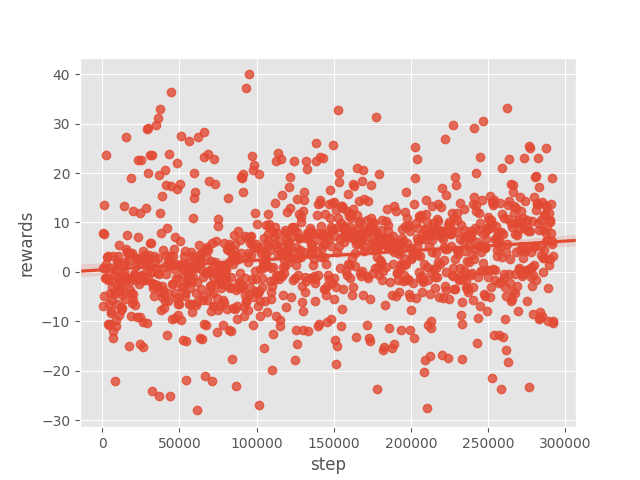

<AxesSubplot:xlabel='step', ylabel='rewards'>

In [17]:
# plot rewards
plt.figure()
df_online, df = load_stats_ddpg(agent)
sns.regplot(x="step", y="rewards", data=df_online, order=1)

In [18]:
# monthly growth
# portfolio_return = (1+df_online.rewards[-100:].mean())

# returns = task.unwrapped.src.data[0,:,:1]
# market_return = (1+returns).mean()
# market_return, portfolio_return

In [19]:
#求回归线的斜率 (get slope of regression line)
import statsmodels.api as sm
df_online_x = df_online['step']
df_online_y = df_online['rewards']

df_online_x = sm.add_constant(df_online_x)
model_reg = sm.OLS(df_online_y, df_online_x)
reg_results = model_reg.fit()
print('Slope of regression line:')
reg_results.params[1]

Slope of regression line:


1.939088626324822e-05

# Test

In [20]:
def test_algo(env, algo, seed=0):
    """
    Runs and algo from https://github.com/Marigold/universal-portfolios on env
    
    https://github.com/Marigold/universal-portfolios/commit/e8970a82427522ef11b1c3cbf681e18b5fe8169c
    """
    env.seed(0)
    np.random.seed(0)

    state = env.reset()
    for i in range(env.unwrapped.sim.steps):
        
        history= pd.DataFrame(state[0,:,:], columns=env.unwrapped.src.asset_names)
        # MPT wants a cash column, and it should be first
        history['CASH']=1
        history=history[['CASH'] + env.unwrapped.src.asset_names]
#         cols = list(history.columns)
#         cols[0]='CASH'
#         history.columns = cols
        
        x=history.iloc[-1]
        
        last_b = env.unwrapped.sim.w0#[1:]

        algo.init_step(history)
        # some don't want history
        try:
            action = algo.step(x, last_b, history)
        except TypeError:
            action = algo.step(x, last_b)
        
        # might by dataframe
        action = getattr(action, 'value', action)
        
        # For upt
        if isinstance(action, np.matrixlib.defmatrix.matrix):
            action = np.array(action.tolist()).T[0]
            
        

        state, reward, done, info = env.step(action)

        if done:
            break   
    df = pd.DataFrame(env.unwrapped.infos)
    df.index = pd.to_datetime(df['date']*1e9)
    return df['portfolio_value'], df

<IPython.core.display.Javascript object>


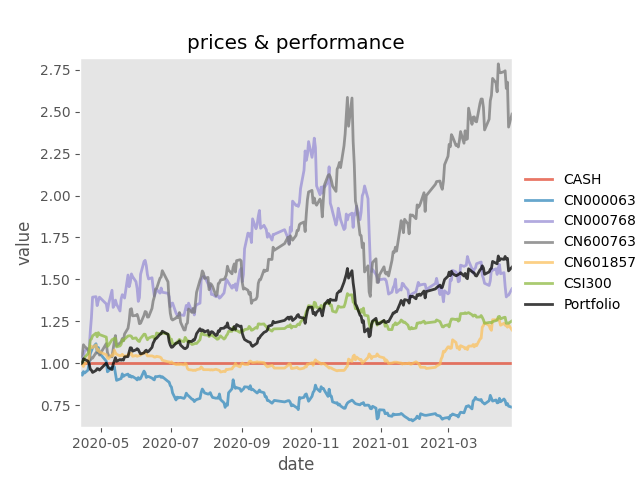

<IPython.core.display.Javascript object>

/home/andy/anaconda3/envs/ddpg/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)



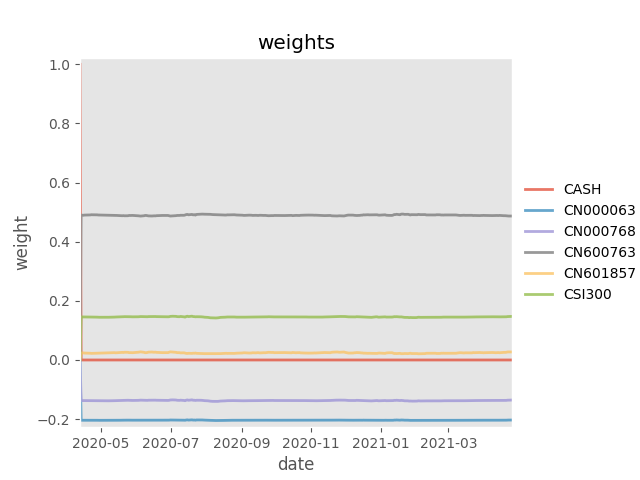

<IPython.core.display.Javascript object>


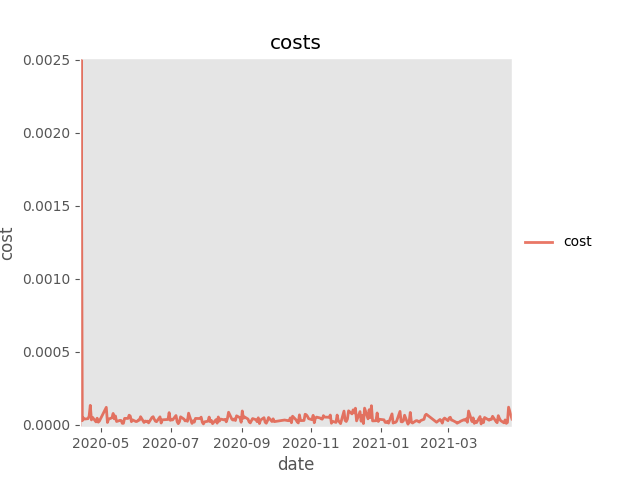

In [21]:
# use test env
df_test = pd.read_hdf('./data/chinaStock_1d.hf',key='test')
test_steps=5000
env_test = task_fn_test()
agent.task = env_test
agent.config.max_episode_length = test_steps
agent.task.reset()
np.random.seed(0)

# run in deterministic mode, no training, no exploration
agent.episode(True)
agent.task.render('notebook')
agent.task.render('notebook', True)

df = pd.DataFrame(agent.task.unwrapped.infos)
df.index = pd.to_datetime(df['date']*1e9)

In [22]:
s=sharpe(df.log_return)
mdd=MDD(df.portfolio_value)
mdd1=MDD1(df.portfolio_value)
s1=sharpe(df.rate_of_return)
sor_log = sortino(df.log_return)
sor_simpe = sortino(df.rate_of_return)


print('回测期日平均简单收益率(average daily simple return):                 \t{: 2.6f}'.format( df.rate_of_return.mean()))
print('回测期日平均对数收益率(average daily log return):                    \t{: 2.6f}'.format(df.log_return.mean()))

print('简单收益率的SR (Annual simple Sharpe ratio):                 \t{: 2.6f}'.format( s1))
print('对数收益率的SR (Annual log Sharpe ratio):                 \t{: 2.6f}'.format( s))

print('简单收益率的sortino比率 (Annual simple sortino ratio):                 \t{: 2.6f}'.format(sor_simpe))
print('对数收益率的sortino比率 (Annual log sortino ratio):                 \t{: 2.6f}'.format(sor_log))

print('最大回撤MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('最大回撤MDD1 (max drawdown):                \t{: 2.6%}'.format( mdd1))

回测期日平均简单收益率(average daily simple return):                 	 0.001941
回测期日平均对数收益率(average daily log return):                    	 0.001792
简单收益率的SR (Annual simple Sharpe ratio):                 	 1.794142
对数收益率的SR (Annual log Sharpe ratio):                 	 1.653335
简单收益率的sortino比率 (Annual simple sortino ratio):                 	 2.557495
对数收益率的sortino比率 (Annual log sortino ratio):                 	 2.309643
最大回撤MDD (max drawdown):                	 25.983636%
最大回撤MDD1 (max drawdown):                	 25.983636%


In [23]:
# from universal import algos
# env = task.unwrapped
# price_cols = [col for col in df.columns if col.startswith('price')]
# for col in price_cols:
#     df[col]=df[col].cumprod()

# df = df[price_cols + ['portfolio_value']]
    
# algo_dict=dict(
#     # Pick the same is in https://arxiv.org/pdf/1706.10059.pdf
#     # Benchmarks
# #     UCRP=algos.UP(),
    
#     # Follow the winner
#     BestSoFar=algos.BestSoFar(cov_window=env_test.unwrapped.src.window_length-1),
# #     UniversalPortfolio=algos.UP(eval_points=1000),
#     ONS=algos.ONS(),
    
#     # Follow the loser
# #     OnlineMovingAverageReversion=algos.OLMAR(window=env.src.window_length-1, eps=10), 
#     RMR=algos.RMR(window=env_test.unwrapped.src.window_length-1, eps=10),
# #     PassiveAggressiveMeanReversion=algos.PAMR(),
    
#     # Pattern matching
#     #     CorrelationDrivenNonparametricLearning=algos.CORN(window=30),
# )
# for name, algo in algo_dict.items():
#     print(name)
#     perf, _ = test_algo(env_test, algo)
#     perf.index=df.index
#     df[name]=perf

# # put portfolio value at end so we plot it on top and can therefore see it
# cols = list(df.columns.drop('portfolio_value'))+['portfolio_value']
# df=df[cols]


# df.plot(alpha=0.5)

In [24]:
Return_hs300 = df['price_CSI300'].pct_change()
Return_hs300.dropna(inplace=True)

ratio_hs300 = df['price_CSI300'] / df['price_CSI300'].shift()
ratio_hs300.dropna(inplace=True)
logReturn_hs300 = np.log(ratio_hs300)

print('CSI300回测期日平均简单收益率(average daily simple return):         \t{: 2.6f}'.format( Return_hs300.mean()))
print('CSI3300回测期日平均对数收益率(average daily log return):           \t{: 2.6f}'.format(logReturn_hs300.mean()))


s_hs300 = sharpe(Return_hs300)
print('CSI3300简单收益率的SR (Annual simple Sharpe ratio):                 \t{: 2.6f}'.format(s_hs300))
s_hs300_lg = sharpe(logReturn_hs300)
print('CSI3300对数收益率的SR (Annual log Sharpe ratio):                    \t{: 2.6f}'.format(s_hs300_lg))

sor_hs300_logreturn = sortino(logReturn_hs300)
sor_hs300_simplereturn = sortino(Return_hs300)
print('CSI3300简单收益率的sortino比率 (Annual simple sortino ratio):                 \t{: 2.6f}'.format(sor_hs300_simplereturn))
print('CSI3300对数收益率的sortino比率 (Annual log sortino ratio):                 \t{: 2.6f}'.format(sor_hs300_logreturn))

mdd1_hs300 = MDD1(df['price_CSI300'])
print('CSI3300最大回撤MDD1 (max drawdown):                \t{: 2.6%}'.format(mdd1_hs300))

CSI300回测期日平均简单收益率(average daily simple return):         	 0.000189
CSI3300回测期日平均对数收益率(average daily log return):           	 0.000025
CSI3300简单收益率的SR (Annual simple Sharpe ratio):                 	 0.165819
CSI3300对数收益率的SR (Annual log Sharpe ratio):                    	 0.022390
CSI3300简单收益率的sortino比率 (Annual simple sortino ratio):                 	 0.268245
CSI3300对数收益率的sortino比率 (Annual log sortino ratio):                 	 0.035541
CSI3300最大回撤MDD1 (max drawdown):                	 9.916018%


In [25]:
df

,cost,date,log_return,market_return,market_value,portfolio_value,price_CASH,price_CN000063,price_CN000768,price_CN600763,...,reward,steps,weight_CASH,weight_CN000063,weight_CN000768,weight_CN600763,weight_CN601857,weight_CSI300,weights_mean,weights_std
date,,,,,,,,,,,,,,,,,,,,,
2020-04-12 16:00:00,0.000000,1.586707e+09,0.000000,1.005910,1.005910,1.000000,1.0,0.944063,1.041032,1.047895,...,0.000000,1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.372678
2020-04-13 16:00:00,0.002500,1.586794e+09,-0.002503,0.998654,1.004556,0.997500,1.0,0.996987,0.997185,0.993580,...,-0.000010,2,0.0,-0.203804,-0.137246,0.489993,0.023331,0.145625,0.052983,0.225601
2020-04-14 16:00:00,0.000029,1.586880e+09,0.008643,0.996545,1.001085,1.006159,1.0,0.987157,0.991530,1.012348,...,0.000034,3,0.0,-0.203791,-0.137289,0.489674,0.023703,0.145543,0.052973,0.225487
2020-04-15 16:00:00,0.000048,1.586966e+09,0.021141,1.014892,1.015994,1.027656,1.0,1.023725,1.010251,1.053972,...,0.000084,4,0.0,-0.203767,-0.137294,0.489412,0.024024,0.145502,0.052979,0.225389
2020-04-16 16:00:00,0.000040,1.587053e+09,-0.003742,1.007979,1.024101,1.023818,1.0,0.990531,1.032131,0.990766,...,-0.000015,5,0.0,-0.203837,-0.137477,0.490048,0.023352,0.145286,0.052895,0.225633
2020-04-19 16:00:00,0.000043,1.587312e+09,-0.010192,1.008513,1.032819,1.013436,1.0,1.018868,1.011469,0.983538,...,-0.000040,6,0.0,-0.203854,-0.137519,0.490182,0.023198,0.145247,0.052876,0.225686
2020-04-20 16:00:00,0.000060,1.587398e+09,-0.015051,1.011018,1.044198,0.998296,1.0,1.047161,0.995680,0.980801,...,-0.000060,7,0.0,-0.203872,-0.137548,0.490342,0.023009,0.145228,0.052860,0.225749
2020-04-21 16:00:00,0.000134,1.587485e+09,-0.034530,1.039367,1.085305,0.964413,1.0,1.052582,1.099783,0.959282,...,-0.000137,8,0.0,-0.203854,-0.137538,0.490558,0.022800,0.145249,0.052869,0.225820
2020-04-22 16:00:00,0.000034,1.587571e+09,-0.005190,1.016975,1.103728,0.959421,1.0,1.015905,1.070513,1.013669,...,-0.000021,9,0.0,-0.203661,-0.137420,0.491227,0.022335,0.145356,0.052973,0.226000


In [26]:
df.to_csv('df_backtest1.csv')

In [27]:
df_online

,steps,rewards,step
episodes,,,
0,252.0,-6.980999,252.0
1,252.0,0.877348,504.0
2,252.0,7.856441,756.0
3,252.0,-4.974622,1008.0
4,252.0,7.615860,1260.0
5,252.0,13.632096,1512.0
6,252.0,0.840027,1764.0
7,252.0,-1.289060,2016.0
8,252.0,23.667842,2268.0


In [28]:
df_online.to_csv('df_online_backtest1.csv')